# GPU rans

In [1]:
import torch
from compressai.entropy_models import EntropyBottleneck

torch.manual_seed(0)
eb = EntropyBottleneck(channels=192).cuda()
eb.update(force=True)

x = torch.randn(32, 192, 8, 8, device="cuda")

# CPU roundtrip
eb.use_gpu_ans = False
s_cpu = eb.compress(x)
xhat_cpu = eb.decompress(s_cpu, (8,8))

# GPU roundtrip
eb.use_gpu_ans = True
s_gpu = eb.compress(x)
xhat_gpu = eb.decompress(s_gpu, (8,8))  # 注意 EntropyBottleneck.decompress签名是 (strings,size)

# 对比
print((xhat_cpu - xhat_gpu).abs().max())


tensor(0., device='cuda:0')


/hwj/project/CompressAI-Science/compressai/entropy_models/entropy_models.py:417: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:1581.)
  merged_u8 = torch.frombuffer(memoryview(merged), dtype=torch.uint8).to(device=cdf.device, non_blocking=False)


# GPU compress align with CPU

In [1]:
import time
import torch
import numpy as np
from compressai.entropy_models import EntropyBottleneck
from compressai.zoo import bmshj2018_factorized

def time_cpu(fn, iters=10, warmup=2):
    for _ in range(warmup):
        fn()
    t0 = time.perf_counter()
    for _ in range(iters):
        fn()
    t1 = time.perf_counter()
    return (t1 - t0) / iters

def time_gpu(fn, iters=50, warmup=10):
    for _ in range(warmup):
        fn()
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(iters):
        fn()
    end.record()
    torch.cuda.synchronize()
    ms = start.elapsed_time(end) / iters
    return ms / 1000.0

def run():
    project_dir = "/hwj"
    quality = 1
    device = "cuda:0"

    net = bmshj2018_factorized(quality=quality, pretrained=False)
    old_state_dict = torch.load(
        f"{project_dir}/data/model/bmshj2018-factorized-prior-{quality}.pth",
        map_location=device,
    )
    net.load_state_dict(old_state_dict)
    net.eval().to(device)

    path = "/hwj/project/aiz-accelerate/data/nyx-dark_matter_density.npy"

    # 1) load npy -> tensor
    arr = np.load(path)
    x0 = torch.from_numpy(arr).float().to(device)

    # 2) analysis transform -> latents
    with torch.no_grad():
        y = net.g_a(x0)

    eb = net.entropy_bottleneck
    # eb.update(force=True)  # 通常 pretrained 模型已更新好，如你不确定可以打开

    torch.manual_seed(0)

    # ------------------------------------------------------------
    # A) compress correctness: CPU bytes == GPU bytes
    # ------------------------------------------------------------
    eb.use_gpu_ans = False
    s_cpu = eb.compress(y)

    eb.use_gpu_ans = True
    s_gpu = eb.compress(y)

    assert len(s_cpu) == len(s_gpu)
    for i in range(len(s_cpu)):
        if s_cpu[i] != s_gpu[i]:
            print("Mismatch at", i, len(s_cpu[i]), len(s_gpu[i]))
            print(s_cpu[i][:64])
            print(s_gpu[i][:64])
            raise SystemExit(1)
    print("Pass verify: CPU compressed == GPU compressed (bytes match)")

    # ------------------------------------------------------------
    # B) decompress correctness (4-way cross check)
    # ------------------------------------------------------------
    size = y.size()[-2:]  # EntropyBottleneck.decompress(strings, size)

    # 1) CPU decode CPU bitstream
    eb.use_gpu_ans = False
    yhat_cpu_from_cpu = eb.decompress(s_cpu, size)

    # 2) GPU decode GPU bitstream
    eb.use_gpu_ans = True
    yhat_gpu_from_gpu = eb.decompress(s_gpu, size)

    # 3) CPU decode GPU bitstream
    eb.use_gpu_ans = False
    yhat_cpu_from_gpu = eb.decompress(s_gpu, size)

    # 4) GPU decode CPU bitstream
    eb.use_gpu_ans = True
    yhat_gpu_from_cpu = eb.decompress(s_cpu, size)

    # 注意：EntropyBottleneck.decompress 会 dequantize 出 float
    def max_abs(a, b):
        return (a - b).abs().max().item()

    m1 = max_abs(yhat_cpu_from_cpu, yhat_gpu_from_gpu)
    m2 = max_abs(yhat_cpu_from_cpu, yhat_cpu_from_gpu)
    m3 = max_abs(yhat_cpu_from_cpu, yhat_gpu_from_cpu)

    print("\n=== Decompress verify ===")
    print(f"max|CPU(cpu)->yhat  - GPU(gpu)->yhat| = {m1}")
    print(f"max|CPU(cpu)->yhat  - CPU(gpu)->yhat| = {m2}")
    print(f"max|CPU(cpu)->yhat  - GPU(cpu)->yhat| = {m3}")

    # 这三个必须为 0（或极小接近 0，如果你 dtype/设备转换引入了差异）
    if m1 != 0.0 or m2 != 0.0 or m3 != 0.0:
        print("Decompress mismatch! (expected exact match)")
        raise SystemExit(2)

    print("Pass verify: CPU/GPU decompress are mutually compatible")

    # ------------------------------------------------------------
    # C) speed tests: compress + decompress
    # ------------------------------------------------------------
    def cpu_compress():
        eb.use_gpu_ans = False
        return eb.compress(y)

    def gpu_compress():
        eb.use_gpu_ans = True
        return eb.compress(y)

    def cpu_decompress_cpu_stream():
        eb.use_gpu_ans = False
        return eb.decompress(s_cpu, size)

    def gpu_decompress_gpu_stream():
        eb.use_gpu_ans = True
        return eb.decompress(s_gpu, size)

    # compress: CPU path iters 小一些（tolist + loop 很慢）
    cpu_comp_sec = time_cpu(cpu_compress, iters=3, warmup=1)
    gpu_comp_sec = time_gpu(gpu_compress, iters=30, warmup=5)

    # decompress: 同理，CPU path iters 小一点
    cpu_decomp_sec = time_cpu(cpu_decompress_cpu_stream, iters=3, warmup=1)
    gpu_decomp_sec = time_gpu(gpu_decompress_gpu_stream, iters=30, warmup=5)

    total_bytes = sum(len(s) for s in s_cpu)
    raw_bytes = y.numel() * 4
    gb_raw = raw_bytes / (1024**3)

    print("\n=== Size ===")
    print("ga output:", y.shape, f"{raw_bytes} bytes", y.dtype)
    print(f"Total compressed bytes: {total_bytes}")
    print(f"CR: {raw_bytes/total_bytes:.2f}")

    print("\n=== Speed: compress ===")
    print(f"CPU compress avg: {cpu_comp_sec*1000:.3f} ms / call")
    print(f"GPU compress avg: {gpu_comp_sec*1000:.3f} ms / call")
    print(f"Speedup: {cpu_comp_sec/gpu_comp_sec:.2f}x")
    print(f"Throughput CPU: {gb_raw/cpu_comp_sec:.6f} GiB/s")
    print(f"Throughput GPU: {gb_raw/gpu_comp_sec:.6f} GiB/s")

    print("\n=== Speed: decompress ===")
    print(f"CPU decompress avg: {cpu_decomp_sec*1000:.3f} ms / call")
    print(f"GPU decompress avg: {gpu_decomp_sec*1000:.3f} ms / call")
    print(f"Speedup: {cpu_decomp_sec/gpu_decomp_sec:.2f}x")
    print(f"Throughput CPU: {gb_raw/cpu_decomp_sec:.6f} GiB/s")
    print(f"Throughput GPU: {gb_raw/gpu_decomp_sec:.6f} GiB/s")

if __name__ == "__main__":
    run()


Mismatch at 0 560 572
b'x\x8d\x81\xbe\x00\x00\x00\x00B\x14\x1c\xa9A\x04\x0cH_\x1d\xde.\xe5\xd6\x8f\xd93\xe3\xea\xed\x11\x03,[>\xdcn\xce\x0f\xd5\xa6\x8a\xd7\x0e\x1fd\xe3yv\xdd\x17\x15\xcdd\xcf\xe8\x9f\xf5\xaf\xa1\xf9Cb\xf7\x89\x15'
b'\x01\x00\x00\x00\x000\x00\x000\x02\x00\x00x\x8d\x81\xbe\x00\x00\x00\x00B\x14\x1c\xa9A\x04\x0cH_\x1d\xde.\xe5\xd6\x8f\xd93\xe3\xea\xed\x11\x03,[>\xdcn\xce\x0f\xd5\xa6\x8a\xd7\x0e\x1fd\xe3yv\xdd\x17\x15\xcdd'


SystemExit: 1

/root/miniconda3/envs/compressai-s/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# GPU compress with controlled P

In [1]:
import time
import torch
import numpy as np
from compressai.zoo import bmshj2018_factorized


def time_cpu(fn, iters=10, warmup=2):
    for _ in range(warmup):
        fn()
    t0 = time.perf_counter()
    for _ in range(iters):
        fn()
    t1 = time.perf_counter()
    return (t1 - t0) / iters


def time_gpu(fn, iters=50, warmup=10):
    for _ in range(warmup):
        fn()
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(iters):
        fn()
    end.record()
    torch.cuda.synchronize()
    ms = start.elapsed_time(end) / iters
    return ms / 1000.0


def max_abs(a, b):
    return (a - b).abs().max().item()


def bytes_total(strings):
    return int(sum(len(s) for s in strings))


def run():
    project_dir = "/hwj"
    quality = 1
    device = "cuda:0"
    P = 10

    model_path = f"{project_dir}/data/model/bmshj2018-factorized-prior-{quality}.pth"
    npy_path = "/hwj/project/aiz-accelerate/data/nyx-dark_matter_density.npy"

    net = bmshj2018_factorized(quality=quality, pretrained=False)
    old_state_dict = torch.load(model_path, map_location=device)
    net.load_state_dict(old_state_dict)
    net.eval().to(device)

    arr = np.load(npy_path)
    x0 = torch.from_numpy(arr).float().to(device)

    with torch.no_grad():
        y = net.g_a(x0)
    eb = net.entropy_bottleneck
    size_hw = y.size()[-2:]

    raw_bytes = int(y.numel() * y.element_size())
    gb_raw = raw_bytes / (1024**3)

    def cpu_compress():
        eb.use_gpu_ans = False
        return eb.compress(y)

    def cpu_decompress(streams):
        eb.use_gpu_ans = False
        return eb.decompress(streams, size_hw)

    def gpu_compress():
        eb.use_gpu_ans = True
        eb.gpu_ans_parallelism = int(P)
        return eb.compress(y)

    def gpu_decompress(streams):
        eb.use_gpu_ans = True
        eb.gpu_ans_parallelism = int(P)
        return eb.decompress(streams, size_hw)

    # ------------------------------------------------------------
    # A) Correctness / self-consistency
    # ------------------------------------------------------------
    print("\n=== A) Self-consistency ===")

    s_cpu1 = cpu_compress()
    y_cpu1 = cpu_decompress(s_cpu1)
    s_cpu2 = cpu_compress()
    y_cpu2 = cpu_decompress(s_cpu2)
    d_cpu_repeat = max_abs(y_cpu1, y_cpu2)
    print(f"CPU repeat max|y1-y2| = {d_cpu_repeat}")
    if d_cpu_repeat != 0.0:
        raise SystemExit("CPU roundtrip is not deterministic / not self-consistent")

    s_gpu1 = gpu_compress()
    y_gpu1 = gpu_decompress(s_gpu1)
    s_gpu2 = gpu_compress()
    y_gpu2 = gpu_decompress(s_gpu2)
    d_gpu_repeat = max_abs(y_gpu1, y_gpu2)
    print(f"GPU repeat max|y1-y2| = {d_gpu_repeat}")
    if d_gpu_repeat != 0.0:
        raise SystemExit("GPU roundtrip is not deterministic / not self-consistent")

    print("\n=== B) CPU vs GPU roundtrip output equality ===")
    d_cpu_gpu = max_abs(y_cpu1, y_gpu1)
    print(f"P={P}, max|CPU_roundtrip - GPU_roundtrip| = {d_cpu_gpu}")
    if d_cpu_gpu == 0.0:
        print("PASS: CPU/GPU roundtrip outputs match exactly.")
    else:
        print("FAIL: CPU/GPU roundtrip outputs differ (symbolization/clamp/support/format mismatch).")

    print("\n=== C) Loss vs original y (max-abs) ===")
    loss_cpu = max_abs(y_cpu1, y)
    loss_gpu = max_abs(y_gpu1, y)
    print(f"max|CPU_roundtrip - y| = {loss_cpu}")
    print(f"max|GPU_roundtrip - y| = {loss_gpu}")

    # ------------------------------------------------------------
    # D) Size / CR (CPU and GPU separately)
    # ------------------------------------------------------------
    total_bytes_cpu = bytes_total(s_cpu1)
    total_bytes_gpu = bytes_total(s_gpu1)

    cr_cpu = (raw_bytes / total_bytes_cpu) if total_bytes_cpu > 0 else float("inf")
    cr_gpu = (raw_bytes / total_bytes_gpu) if total_bytes_gpu > 0 else float("inf")

    print("\n=== D) Size / Compression Ratio ===")
    print("ga output:", tuple(y.shape), f"{raw_bytes} bytes", y.dtype)
    print(f"CPU compressed bytes: {total_bytes_cpu}")
    print(f"GPU compressed bytes: {total_bytes_gpu}")
    print(f"CR CPU: {cr_cpu:.4f}")
    print(f"CR GPU: {cr_gpu:.4f}")

    # ------------------------------------------------------------
    # E) Speed (compress and decompress separately, CPU/GPU)
    # ------------------------------------------------------------
    # IMPORTANT: For decompress timing, reuse precomputed streams so you're measuring decode only.
    # For compress timing, just call compress.
    print("\n=== E) Speed ===")

    # --- compress-only
    cpu_comp_sec = time_cpu(cpu_compress, iters=3, warmup=1)
    gpu_comp_sec = time_gpu(gpu_compress, iters=3, warmup=1)

    # --- decompress-only (reuse s_cpu1 / s_gpu1)
    cpu_decomp_sec = time_cpu(lambda: cpu_decompress(s_cpu1), iters=3, warmup=1)
    gpu_decomp_sec = time_gpu(lambda: gpu_decompress(s_gpu1), iters=3, warmup=1)

    print("\n--- Compress only ---")
    print(f"CPU compress: {cpu_comp_sec*1000:.3f} ms/call | {gb_raw/cpu_comp_sec:.6f} GiB/s")
    print(f"GPU compress: {gpu_comp_sec*1000:.3f} ms/call | {gb_raw/gpu_comp_sec:.6f} GiB/s")
    print(f"Speedup (CPU/GPU): {cpu_comp_sec/gpu_comp_sec:.2f}x")

    print("\n--- Decompress only ---")
    print(f"CPU decompress: {cpu_decomp_sec*1000:.3f} ms/call | {gb_raw/cpu_decomp_sec:.6f} GiB/s")
    print(f"GPU decompress: {gpu_decomp_sec*1000:.3f} ms/call | {gb_raw/gpu_decomp_sec:.6f} GiB/s")
    print(f"Speedup (CPU/GPU): {cpu_decomp_sec/gpu_decomp_sec:.2f}x")

    print("\n=== Final verdict ===")
    if d_cpu_repeat == 0.0 and d_gpu_repeat == 0.0 and d_cpu_gpu == 0.0:
        print("PASS: CPU/GPU are self-consistent and mutually identical on roundtrip output.")
    else:
        print("FAIL: See A/B for mismatch details.")


if __name__ == "__main__":
    run()



=== A) Self-consistency ===
CPU repeat max|y1-y2| = 0.0
GPU repeat max|y1-y2| = 0.0

=== B) CPU vs GPU roundtrip output equality ===
P=10, max|CPU_roundtrip - GPU_roundtrip| = 0.0
PASS: CPU/GPU roundtrip outputs match exactly.

=== C) Loss vs original y (max-abs) ===
max|CPU_roundtrip - y| = 0.49999985098838806
max|GPU_roundtrip - y| = 0.49999985098838806

=== D) Size / Compression Ratio ===
ga output: (512, 192, 8, 8) 25165824 bytes torch.float32
CPU compressed bytes: 261808
GPU compressed bytes: 315096
CR CPU: 96.1232
CR GPU: 79.8672

=== E) Speed ===

--- Compress only ---
CPU compress: 607.476 ms/call | 0.038582 GiB/s
GPU compress: 4.769 ms/call | 4.914978 GiB/s
Speedup (CPU/GPU): 127.39x

--- Decompress only ---
CPU decompress: 826.015 ms/call | 0.028374 GiB/s
GPU decompress: 5.591 ms/call | 4.192183 GiB/s
Speedup (CPU/GPU): 147.75x

=== Final verdict ===
PASS: CPU/GPU are self-consistent and mutually identical on roundtrip output.


# Influence of P on CR and Thr


=== GPU sweep (PACKED GPU-only) ===
Raw bytes: 25165824

--- P=1 ---
packed tensor shape: torch.Size([1215672])
packed tensor numel: 1215672
sizes_u16 tensor numel: 98304
Compressed bytes: 1215672
CR: 20.7012
Compress:   0.490 ms | 47.811 GiB/s
Decompress: 0.321 ms | 73.075 GiB/s

--- P=2 ---
packed tensor shape: torch.Size([725240])
packed tensor numel: 725240
sizes_u16 tensor numel: 49152
Compressed bytes: 725240
CR: 34.7000
Compress:   0.435 ms | 53.838 GiB/s
Decompress: 0.327 ms | 71.661 GiB/s

--- P=3 ---
packed tensor shape: torch.Size([562668])
packed tensor numel: 562668
sizes_u16 tensor numel: 32768
Compressed bytes: 562668
CR: 44.7259
Compress:   0.459 ms | 51.064 GiB/s
Decompress: 0.313 ms | 74.847 GiB/s

--- P=4 ---
packed tensor shape: torch.Size([482836])
packed tensor numel: 482836
sizes_u16 tensor numel: 24576
Compressed bytes: 482836
CR: 52.1209
Compress:   0.500 ms | 46.874 GiB/s
Decompress: 0.318 ms | 73.616 GiB/s

--- P=6 ---
packed tensor shape: torch.Size([405064

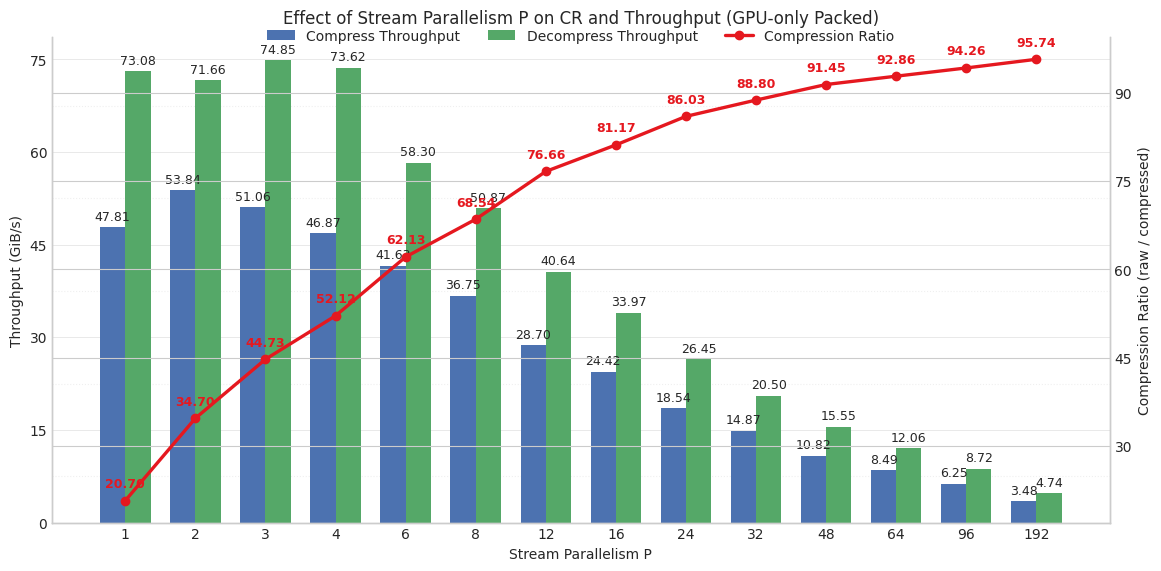

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from compressai.zoo import bmshj2018_factorized

# 你现在的 GPU-only API：eb.compress(y) 返回 PackedANS，而不是 List[bytes]
# 因此：
# 1) bytes_total() 要改成读 packed.sizes.sum()
# 2) decompress() 直接传 packed，不再传 List[bytes]
# 3) eb.use_gpu_ans_packed=True（并且建议把 eb.use_gpu_ans=False，避免走旧慢路径）


def time_gpu(fn, iters=20, warmup=10):
    for _ in range(warmup):
        fn()
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(iters):
        fn()
    end.record()
    torch.cuda.synchronize()
    ms = start.elapsed_time(end) / iters
    return ms / 1000.0


def packed_total_bytes(packed) -> int:
    # packed.sizes: CUDA int32 [B]
    # 读回一个标量（这一步只影响统计/打印，不影响 coder 吞吐）
    print("packed tensor shape:", packed.packed.shape)
    print("packed tensor numel:", packed.packed.numel())
    print("sizes_u16 tensor numel:", packed.sizes_u16.numel())
    return int(packed.packed.numel())

def run():
    # ------------------------------------------------------------
    # Config
    # ------------------------------------------------------------
    project_dir = "/hwj"
    quality = 1
    device = "cuda:0"

    # P_list = [1, 2, 4, 8, 16, 32, 64, 128, 256]
    P_list = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 192]

    model_path = f"{project_dir}/data/model/bmshj2018-factorized-prior-{quality}.pth"
    npy_path = "/hwj/project/aiz-accelerate/data/nyx-dark_matter_density.npy"

    # ------------------------------------------------------------
    # Load model / data
    # ------------------------------------------------------------
    net = bmshj2018_factorized(quality=quality, pretrained=False)
    state = torch.load(model_path, map_location=device)
    net.load_state_dict(state)
    net.eval().to(device)

    arr = np.load(npy_path)
    x0 = torch.from_numpy(arr).float().to(device)

    with torch.no_grad():
        y = net.g_a(x0)

    eb = net.entropy_bottleneck
    size_hw = y.size()[-2:]

    raw_bytes = int(y.numel() * y.element_size())
    gb_raw = raw_bytes / (1024**3)

    # ------------------------------------------------------------
    # GPU-only helpers
    # ------------------------------------------------------------
    def gpu_compress_packed(P):
        eb.use_gpu_ans = True         
        eb.gpu_ans_parallelism = int(P)
        return eb.compress(y)          # -> PackedANS(arena,sizes,stride_cpu)

    def gpu_decompress_packed(packed, P):
        eb.use_gpu_ans = True
        eb.gpu_ans_parallelism = int(P)
        return eb.decompress(packed, size_hw)  # packed 直接喂给 decompress

    # ------------------------------------------------------------
    # Sweep P
    # ------------------------------------------------------------
    cr_list = []
    thr_comp_list = []
    thr_decomp_list = []

    print("\n=== GPU sweep (PACKED GPU-only) ===")
    print("Raw bytes:", raw_bytes)

    for P in P_list:
        print(f"\n--- P={P} ---")

        # build one packed stream batch
        packed = gpu_compress_packed(P)
        total_bytes = packed_total_bytes(packed)
        cr = raw_bytes / max(1, total_bytes)

        # timing
        t_comp = time_gpu(lambda: gpu_compress_packed(P))
        t_decomp = time_gpu(lambda: gpu_decompress_packed(packed, P))

        thr_comp = gb_raw / t_comp
        thr_decomp = gb_raw / t_decomp

        print(f"Compressed bytes: {total_bytes}")
        print(f"CR: {cr:.4f}")
        print(f"Compress:   {t_comp*1000:.3f} ms | {thr_comp:.3f} GiB/s")
        print(f"Decompress: {t_decomp*1000:.3f} ms | {thr_decomp:.3f} GiB/s")

        cr_list.append(cr)
        thr_comp_list.append(thr_comp)
        thr_decomp_list.append(thr_decomp)

    # ------------------------------------------------------------
    # Visualization (单图，不改你的配色逻辑，只把数据源换了)
    # ------------------------------------------------------------
    import matplotlib.ticker as mticker

    Ps = np.array(P_list)
    cr_arr = np.array(cr_list)
    thr_c = np.array(thr_comp_list)
    thr_d = np.array(thr_decomp_list)

    x = np.arange(len(Ps))
    width = 0.36

    plt.style.use("seaborn-v0_8-whitegrid")

    fig, ax1 = plt.subplots(figsize=(11.5, 5.6), constrained_layout=True)

    color_comp = "#4C72B0"
    color_decomp = "#55A868"
    color_cr = "#E5181F"

    bars_c = ax1.bar(x - width / 2, thr_c, width, label="Compress Throughput", color=color_comp)
    bars_d = ax1.bar(x + width / 2, thr_d, width, label="Decompress Throughput", color=color_decomp)

    ax1.set_xlabel("Stream Parallelism P")
    ax1.set_ylabel("Throughput (GiB/s)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(Ps)

    ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
    ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
    ax1.grid(True, axis="y", which="major", linewidth=0.6, alpha=0.5)
    ax1.grid(True, axis="y", which="minor", linestyle=":", alpha=0.3)
    ax1.grid(False, axis="x")

    ax1.bar_label(bars_c, fmt="%.2f", padding=3, fontsize=9)
    ax1.bar_label(bars_d, fmt="%.2f", padding=3, fontsize=9)

    ax2 = ax1.twinx()
    (line_cr,) = ax2.plot(x, cr_arr, color=color_cr, marker="o", markersize=6, linewidth=2.4, label="Compression Ratio")
    ax2.set_ylabel("Compression Ratio (raw / compressed)")
    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))

    for xi, cr in zip(x, cr_arr):
        ax2.annotate(
            f"{cr:.2f}",
            xy=(xi, cr),
            xytext=(0, 9.5),
            textcoords="offset points",
            ha="center",
            fontsize=9,
            fontweight="bold",
            color=color_cr,
        )

    ax1.set_title("Effect of Stream Parallelism P on CR and Throughput (GPU-only Packed)", pad=10)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    fig.legend(h1 + h2, l1 + l2, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.98))

    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)

    plt.savefig("/hwj/project/CompressAI-Science/assets/P-control.png")
    plt.show()


if __name__ == "__main__":
    run()


# Profile of P-rANS

In [1]:
import os
import torch
import numpy as np
from compressai.zoo import bmshj2018_factorized


def run():
    # ------------------------------------------------------------
    # Config
    # ------------------------------------------------------------
    project_dir = "/hwj"
    quality = 1
    device = "cuda:0"

    # 你要 profile 的并行度
    # P_list = [8, 16, 32, 64, 128, 256]
    # P_list = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 192]
    P_list = [12]

    model_path = f"{project_dir}/data/model/bmshj2018-factorized-prior-{quality}.pth"
    npy_path = "/hwj/project/aiz-accelerate/data/nyx-dark_matter_density.npy"

    # profile 输出目录
    out_dir = "./profiles_gpu_packed"
    os.makedirs(out_dir, exist_ok=True)

    # profile 控制：warmup/active 越大 trace 越大
    warmup_steps = 2
    active_steps = 6  # 真正记录的 step 数
    repeat = 1        # 想要更稳可以 repeat>1，但 trace 也会倍增

    # ------------------------------------------------------------
    # Load model / data
    # ------------------------------------------------------------
    net = bmshj2018_factorized(quality=quality, pretrained=False)
    state = torch.load(model_path, map_location=device)
    net.load_state_dict(state)
    net.eval().to(device)

    arr = np.load(npy_path)
    x0 = torch.from_numpy(arr).float().to(device)

    with torch.no_grad():
        y = net.g_a(x0)

    eb = net.entropy_bottleneck
    eb.use_gpu_ans = True
    size_hw = y.size()[-2:]


    @torch.no_grad()
    def do_compress(P: int):
        eb.gpu_ans_parallelism = int(P)
        return eb.compress(y)  # -> PackedANS

    @torch.no_grad()
    def do_decompress(packed, P: int):
        eb.gpu_ans_parallelism = int(P)
        return eb.decompress(packed, size_hw)

    # ------------------------------------------------------------
    # Profiling helpers
    # ------------------------------------------------------------
    def profile_op(name: str, fn_step, trace_path: str):
        """
        用 torch.profiler 记录 GPU kernel / CPU 调度信息，并导出 trace。
        fn_step: 每次调用代表一个 step（会被调用 warmup+active 次）
        """
        activities = [torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]

        sched = torch.profiler.schedule(
            wait=0,
            warmup=warmup_steps,
            active=active_steps,
            repeat=repeat
        )

        # 注意：profile_memory / record_shapes 会让 trace 变大
        with torch.profiler.profile(
            activities=activities,
            schedule=sched,
            on_trace_ready=torch.profiler.tensorboard_trace_handler(
                os.path.dirname(trace_path),  # 写到目录
                worker_name=os.path.splitext(os.path.basename(trace_path))[0],
            ),
            record_shapes=True,
            profile_memory=True,
            with_stack=False,
            with_flops=False,
        ) as prof:
            for _ in range((warmup_steps + active_steps) * repeat):
                fn_step()
                # 让 profiler 进入下一步
                prof.step()

        # 控制台打印一个总结表（按 CUDA time 排序）
        print(f"\n==== {name} profiler table (top 30, sorted by CUDA time) ====")
        print(prof.key_averages(group_by_input_shape=False).table(
            sort_by="cuda_time_total",
            row_limit=30
        ))

        # 另外导出一个 chrome trace（可选，文件较大）
        # 注意：tensorboard_trace_handler 已经生成了一份 trace/event 文件
        try:
            prof.export_chrome_trace(trace_path)
            print(f"[Saved chrome trace] {trace_path}")
        except Exception as e:
            print(f"[WARN] export_chrome_trace failed: {e}")

    # ------------------------------------------------------------
    # Sweep P: profile compress / decompress
    # ------------------------------------------------------------
    print("\n=== GPU PACKED Profiling Sweep ===")
    for P in P_list:
        print(f"\n--- P={P} ---")

        # 先准备一个 packed 给解压用（避免把 compress 也混进 decompress 的 profile）
        packed = do_compress(P)
        torch.cuda.synchronize()

        # ---- Profile compress ----
        def step_compress():
            torch.cuda.nvtx.range_push(f"compress_P{P}")
            _ = do_compress(P)
            torch.cuda.nvtx.range_pop()
            # 这里不强制 synchronize，让 profiler 自己记录异步流；
            # 如需更“墙钟时间”可加 synchronize，但会影响 kernel overlap
            # torch.cuda.synchronize()

        trace_c = os.path.join(out_dir, f"trace_compress_P{P}.json")
        profile_op(f"COMPRESS (P={P})", step_compress, trace_c)

        # ---- Profile decompress ----
        def step_decompress():
            torch.cuda.nvtx.range_push(f"decompress_P{P}")
            _ = do_decompress(packed, P)
            torch.cuda.nvtx.range_pop()

        trace_d = os.path.join(out_dir, f"trace_decompress_P{P}.json")
        profile_op(f"DECOMPRESS (P={P})", step_decompress, trace_d)

    print(f"\nAll traces are under: {os.path.abspath(out_dir)}")
    print("Tip: open trace_*.json with chrome://tracing or Perfetto.")


if __name__ == "__main__":
    run()


=== GPU PACKED Profiling Sweep ===

--- P=12 ---

==== COMPRESS (P=12) profiler table (top 30, sorted by CUDA time) ====
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.00%       0.000us         0.00%       0.000us   